In [ ]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [ ]:

# Load the dataset
data = pd.read_csv('covid_19_clean_complete.csv')
print(data.head(15))

# Filter for US data
data = data[data['Country/Region'] == 'US']
data.reset_index(drop=True, inplace=True)

# Ensure 'Date' is in datetime format and sort data by Date
data['Date'] = pd.to_datetime(data['Date'])
data = data.sort_values('Date')

                  Province/State       Country/Region       Lat        Long  \
0                            NaN          Afghanistan  33.93911   67.709953   
1                            NaN              Albania  41.15330   20.168300   
2                            NaN              Algeria  28.03390    1.659600   
3                            NaN              Andorra  42.50630    1.521800   
4                            NaN               Angola -11.20270   17.873900   
5                            NaN  Antigua and Barbuda  17.06080  -61.796400   
6                            NaN            Argentina -38.41610  -63.616700   
7                            NaN              Armenia  40.06910   45.038200   
8   Australian Capital Territory            Australia -35.47350  149.012400   
9                New South Wales            Australia -33.86880  151.209300   
10            Northern Territory            Australia -12.46340  130.845600   
11                    Queensland            Australi

/var/folders/v7/c7_xhzbn47n7kzmqg4jkhntc0000gn/T/ipykernel_39373/2424862158.py:10: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['Date'] = pd.to_datetime(data['Date'])


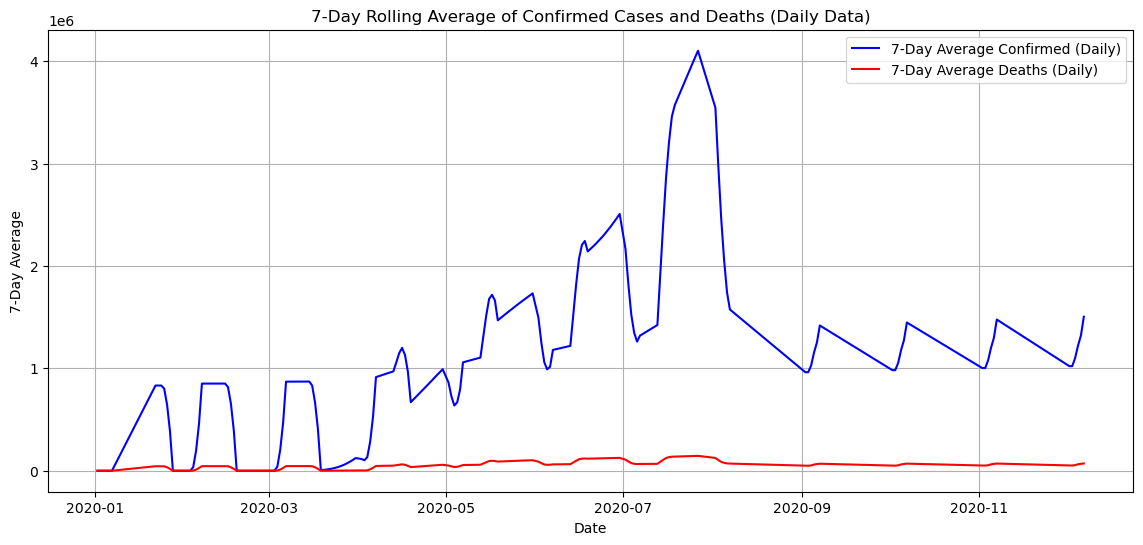

In [ ]:
# Calculate daily new cases, deaths, and recovered
data['New Cases'] = data['Confirmed'].diff().fillna(0).clip(lower=0)
data['New Deaths'] = data['Deaths'].diff().fillna(0).clip(lower=0)
data['New Recovered'] = data['Recovered'].diff().fillna(0).clip(lower=0)

# Calculate 7-day rolling averages
data['Confirmed_7day_Avg'] = data['Confirmed'].rolling(window=7).mean().fillna(0)
data['Deaths_7day_Avg'] = data['Deaths'].rolling(window=7).mean().fillna(0)

# Group by YearMonth and aggregate numeric columns
data['YearMonth'] = data['Date'].dt.to_period('M')
monthly_data = data.groupby('YearMonth')[['Confirmed', 'Deaths', 'Recovered', 'New Cases', 'New Deaths',
                                          'New Recovered', 'Confirmed_7day_Avg', 'Deaths_7day_Avg']].sum().reset_index()

# Convert YearMonth back to datetime format for plotting
monthly_data['YearMonth'] = monthly_data['YearMonth'].dt.to_timestamp()

# Plot daily rolling averages
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Confirmed_7day_Avg'], label='7-Day Average Confirmed (Daily)', color='blue')
plt.plot(data['Date'], data['Deaths_7day_Avg'], label='7-Day Average Deaths (Daily)', color='red')
plt.xlabel('Date')
plt.ylabel('7-Day Average')
plt.title('7-Day Rolling Average of Confirmed Cases and Deaths (Daily Data)')
plt.legend()
plt.grid()
plt.show()

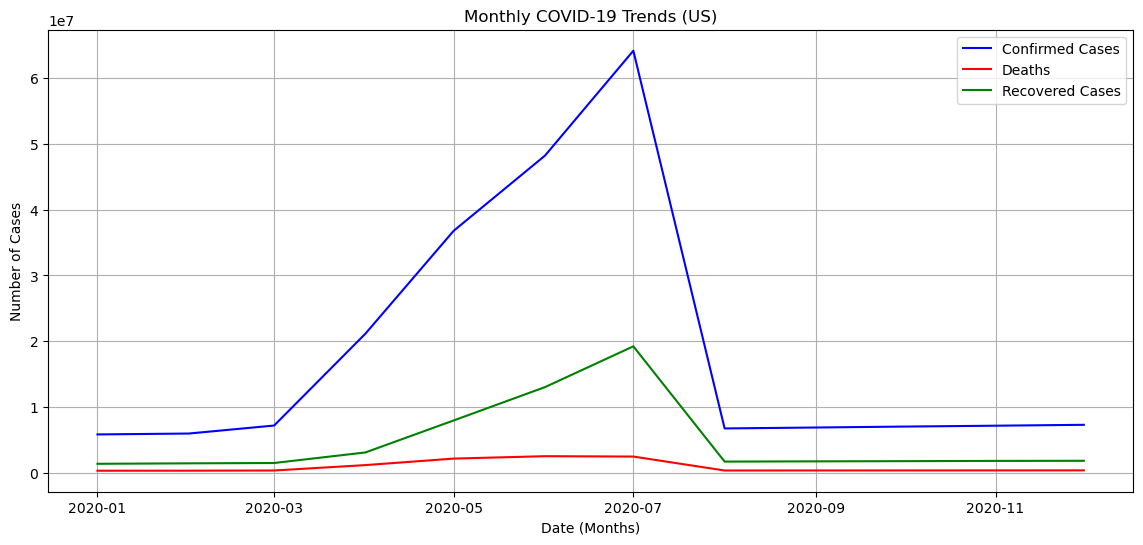

In [ ]:

# Plot monthly trends
plt.figure(figsize=(14, 6))
plt.plot(monthly_data['YearMonth'], monthly_data['Confirmed'], label='Confirmed Cases', color='blue')
plt.plot(monthly_data['YearMonth'], monthly_data['Deaths'], label='Deaths', color='red')
plt.plot(monthly_data['YearMonth'], monthly_data['Recovered'], label='Recovered Cases', color='green')
plt.xlabel('Date (Months)')
plt.ylabel('Number of Cases')
plt.title('Monthly COVID-19 Trends (US)')
plt.legend()
plt.grid()
plt.show()

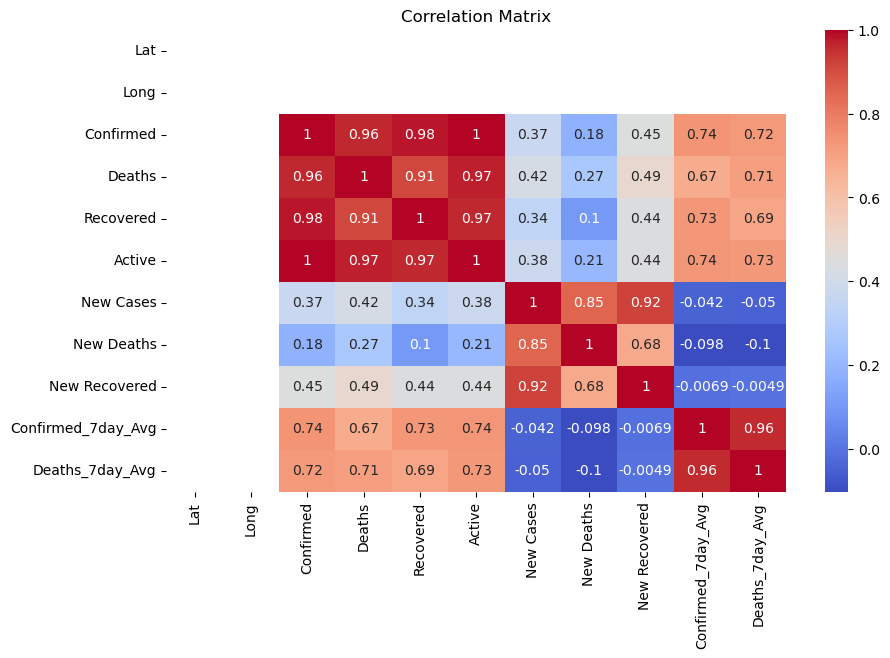

In [ ]:
# Correlation heatmap for numeric data
numeric_data = data.select_dtypes(include=[np.number])  # Select only numeric columns
plt.figure(figsize=(10, 6))
sns.heatmap(numeric_data.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:

# Define features and target for predicting confirmed cases
X = data[['New Cases', 'New Deaths', 'Confirmed_7day_Avg']]
y = data['Confirmed']

# Handle missing values
X.fillna(0, inplace=True)
y.fillna(0, inplace=True)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


/var/folders/v7/c7_xhzbn47n7kzmqg4jkhntc0000gn/T/ipykernel_39373/4192439121.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X.fillna(0, inplace=True)


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=10, random_state=42)
xgb_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Calculate Accuracy
accuracy = 1 - (mse / np.var(y_test))

print("XGBoost Metrics:")
print(f"Mean Squared Error (MSE): {mse}")
print(f"R-squared (R2): {r2}")
print(f"Regression Accuracy: {accuracy * 100:.2f}%")

XGBoost Metrics:
Mean Squared Error (MSE): 226030583808.0
R-squared (R2): 0.8455777168273926
Regression Accuracy: 84.56%


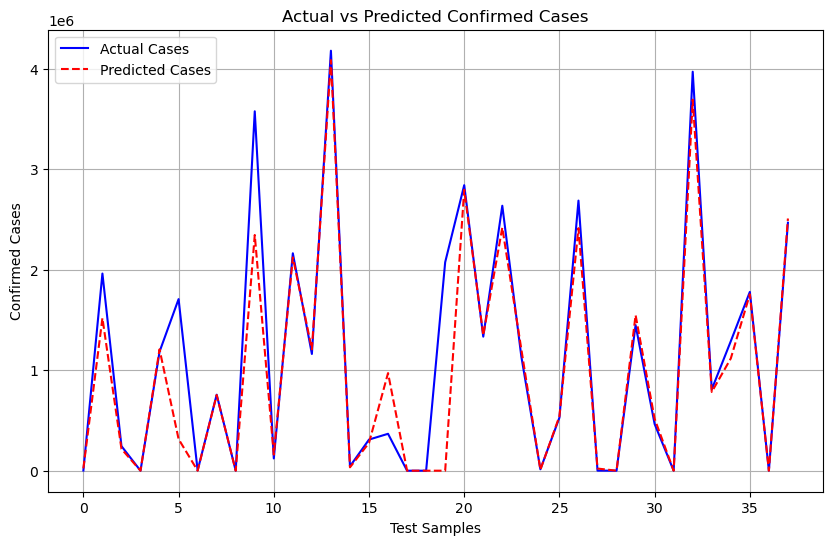

Predicted Confirmed Cases for Future Input: 314840.28125


In [ ]:


# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(y_test.values, label='Actual Cases', color='blue')
plt.plot(y_pred, label='Predicted Cases', color='red', linestyle='--')
plt.xlabel('Test Samples')
plt.ylabel('Confirmed Cases')
plt.title('Actual vs Predicted Confirmed Cases')
plt.legend()
plt.grid()
plt.show()

# Example prediction for future input
future_input = [[100000, 2000, 500000]]  # Example: New Cases, New Deaths, 7-day Average Confirmed
future_prediction = xgb_model.predict(future_input)
print(f"Predicted Confirmed Cases for Future Input: {future_prediction[0]}")

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Random Forest Regressor
print("Random Forest Regressor:")

# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Predict and evaluate Random Forest
y_pred_rf = rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

# Calculate Accuracy
accuracy_rf = 1 - (mse_rf / np.var(y_test))

print("Random Forest Metrics:")
print(f"Mean Squared Error (MSE): {mse_rf}")
print(f"R-squared (R2): {r2_rf}")
print(f"Regression Accuracy: {accuracy_rf * 100:.2f}%")

Random Forest Regressor:
Random Forest Metrics:
Mean Squared Error (MSE): 176437248450.95642
R-squared (R2): 0.8794595163739627
Regression Accuracy: 87.95%


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# Linear Regression
print("\nLinear Regression:")

# Train Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict and evaluate Linear Regression
y_pred_lr = lr_model.predict(X_test)
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

# Calculate Accuracy
accuracy_lr = 1 - (mse_lr / np.var(y_test))

print("Linear Regression Metrics:")
print(f"Mean Squared Error (MSE): {mse_lr}")
print(f"R-squared (R2): {r2_lr}")
print(f"Regression Accuracy: {accuracy_lr * 100:.2f}%")


Linear Regression:
Linear Regression Metrics:
Mean Squared Error (MSE): 600830896389.6891
R-squared (R2): 0.5895172506705113
Regression Accuracy: 58.95%
